<a href="https://colab.research.google.com/github/Cintia0707/Hello-World/blob/master/Copia_de_clasificRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import kagglehub

In [ ]:
path = kagglehub.dataset_download("CooperUnion/anime-recommendations-database")
df_anime = pd.read_csv(f"{path}/anime.csv")

Using Colab cache for faster access to the 'anime-recommendations-database' dataset.


In [ ]:
df_anime = df_anime.dropna()

In [ ]:
threshold = df_anime['members'].quantile(0.75)
df_anime['is_popular'] = (df_anime['members'] >= threshold).astype(int)

In [ ]:
df_anime = pd.get_dummies(df_anime, columns=['type'])

In [ ]:
df_anime['genre'] = df_anime['genre'].apply(lambda x: x.split(', '))
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(df_anime['genre'])
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_)

In [ ]:
X = pd.concat([df_anime[['rating', 'episodes']].reset_index(drop=True),
               df_anime.filter(like='type_').reset_index(drop=True),
               genre_df.reset_index(drop=True)], axis=1)
display(X.head())

,rating,episodes,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,Action,Adventure,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,9.37,1,True,False,False,False,False,False,0,0,...,0,0,0,0,0,1,0,0,0,0
1,9.26,64,False,False,False,False,False,True,1,1,...,0,0,0,0,0,0,0,0,0,0
2,9.25,51,False,False,False,False,False,True,1,0,...,0,0,0,0,0,0,0,0,0,0
3,9.17,24,False,False,False,False,False,True,0,0,...,0,0,0,0,0,0,1,0,0,0
4,9.16,51,False,False,False,False,False,True,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X['episodes'] = pd.to_numeric(X['episodes'], errors='coerce').fillna(0)
y = df_anime['is_popular']
display(y.head())

,is_popular
0,1
1,1
2,1
3,1
4,1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
print("MÉTRICAS DE EVALUACIÓN ")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

MÉTRICAS DE EVALUACIÓN 
Accuracy: 0.8869
Precision: 0.8029
Recall: 0.7255
F1-Score: 0.7622


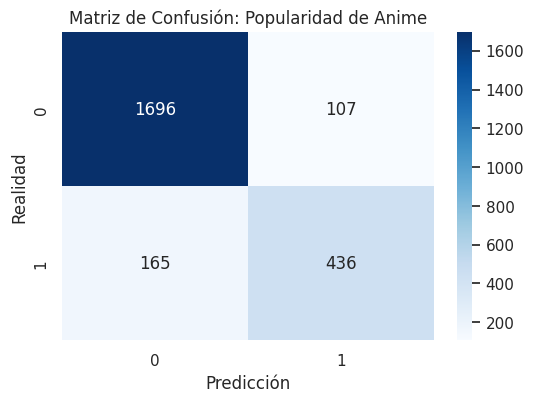

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión: Popularidad de Anime')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

In [ ]:
features = X.columns
importances = clf.feature_importances_
indices = np.argsort(importances)[-10:]

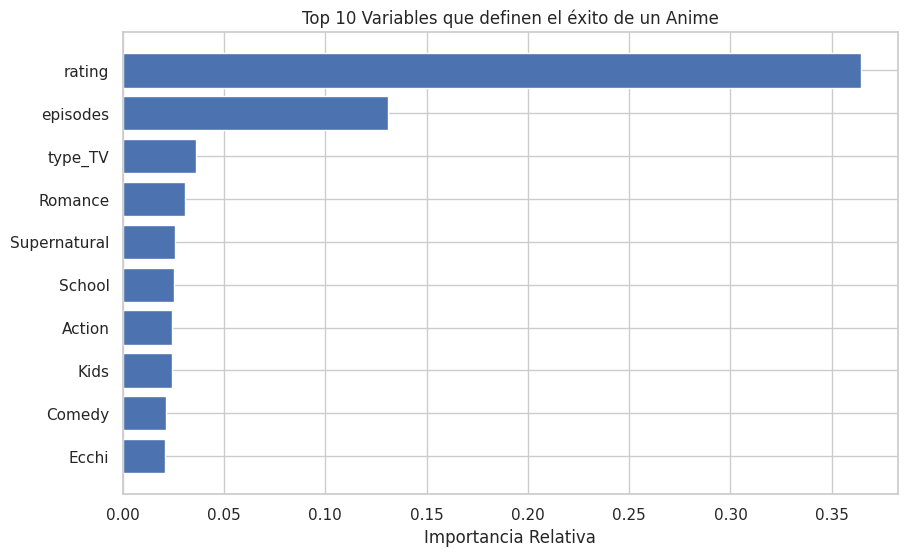

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Top 10 Variables que definen el éxito de un Anime')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Importancia Relativa')
plt.show()

visualizacion

In [ ]:
sns.set_theme(style="whitegrid")

In [ ]:
plot_df = X.copy()
plot_df['Popularidad'] = y.replace({0: 'Nicho/Baja', 1: 'Alta Popularidad'})

Creamos el Pairplot

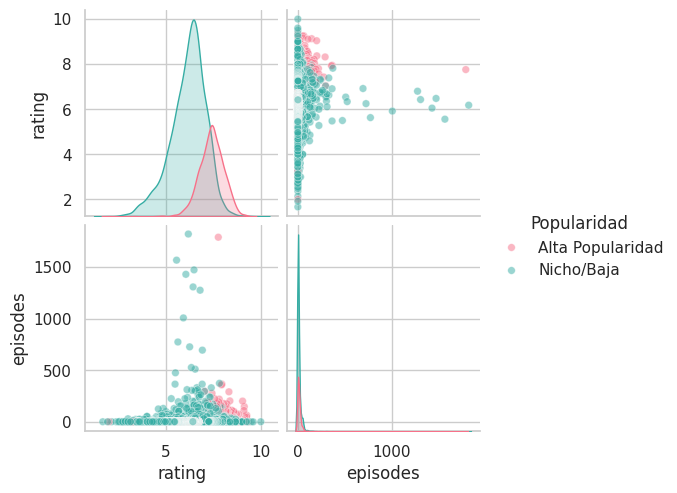

In [ ]:
g = sns.pairplot(
    plot_df[['rating', 'episodes', 'Popularidad']],
    hue='Popularidad',
    palette='husl',
    diag_kind="kde", # Curvas de densidad en la diagonal
    plot_kws={'alpha': 0.5, 's': 30} # Transparencia para ver solapamiento
)

In [ ]:
g.fig.suptitle("Figura 1. Análisis de Relaciones y Distribuciones por Clase de Popularidad", y=1.02, fontsize=14)
plt.show()

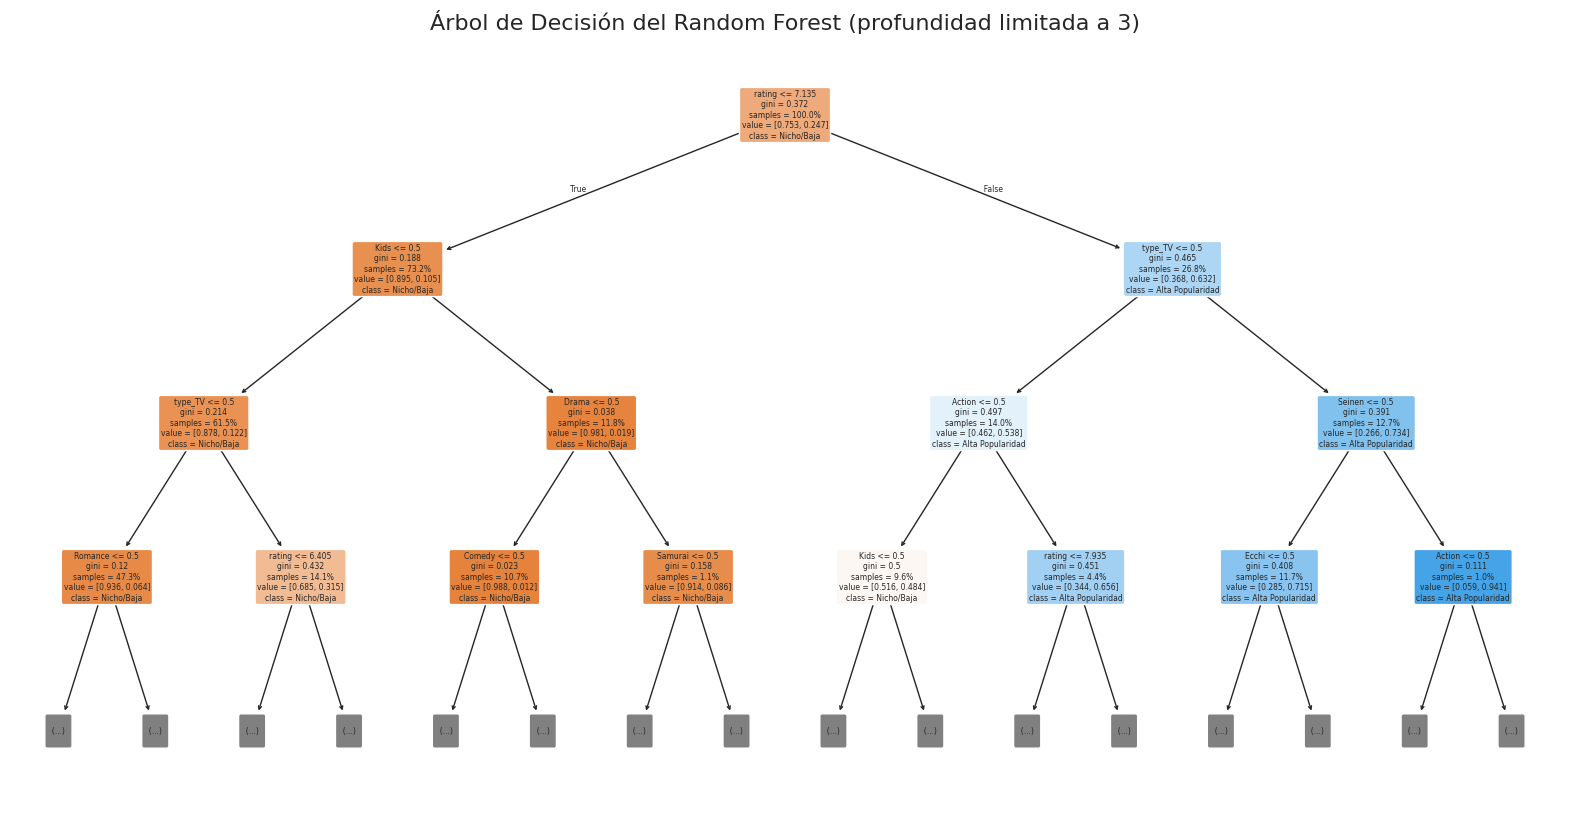

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
# Select one tree from the forest to visualize
tree_to_visualize = clf.estimators_[0]
plot_tree(tree_to_visualize,
          feature_names=X.columns.tolist(),
          class_names=['Nicho/Baja', 'Alta Popularidad'],
          filled=True,
          rounded=True,
          proportion=True,
          max_depth=3 # Limit depth for better readability
         )
plt.title('Árbol de Decisión del Random Forest (profundidad limitada a 3)', fontsize=16)
plt.show()

In [ ]:
def predecir_exito_netflix (episodios, tipo_tv, generos_lista):

  input_data = pd.DataFrame(0, index=[0], columns=X.columns)

  input_data['rating'] = df_anime['rating'].mean()
  input_data['episodes'] = episodios

  if 'type_TV':
     if 'type_TV' in input_data.columns:
         input_data.at[0, 'type_TV'] = 1

  for g in generos_lista:
      if g in input_data.columns:
          input_data.at[0, g] = 1

  prediccion = clf.predict(input_data)[0]

  if prediccion == 1:
        return "potencial para ser popular"
  else:
        return "apunta a ser no popular"

print(predecir_exito_netflix(12, True ,[ 'Action', 'Sci-Fi']))

potencial para ser popular


In [ ]:
# Lista de proyectos optimizados para ser populares
proyectos_exitosos = [
    {
        'Nombre': 'Cyber-Legends: Origins',
        'Episodios': 24,
        'Géneros': ['Action', 'Sci-Fi', 'Adventure' ],
        'Tipo_TV': True
    },
    {
        'Nombre': 'Love in the Digital Age',
        'Episodios': 12,
        'Géneros': ['Romance', 'Comedy', 'School'],
        'Tipo_TV': True
    },
    {
        'Nombre': 'The Last Exorcist',
        'Episodios': 26,
        'Géneros': ['Supernatural', 'Action', 'Fantasy'],
        'Tipo_TV': True
    },
    {
        'Nombre': 'Galactic Battles',
        'Episodios': 50,
        'Géneros': ['Space', 'Mecha', 'Military'],
        'Tipo_TV': True
    },
    {
        'Nombre': 'Mystery of the Red Moon',
        'Episodios': 13,
        'Géneros': ['Mystery', 'Supernatural', 'Thriller'],
        'Tipo_TV': True
    }
]

# Procesamiento y visualización con el nuevo estilo azul
resultados_exito = []

for p in proyectos_exitosos:
    veredicto = predecir_exito_netflix(p['Episodios'], p['Tipo_TV'], p['Géneros'])
    resultados_exito.append({
        'Proyecto': p['Nombre'],
        'Géneros': ", ".join(p['Géneros']),
        'Episodios': p['Episodios'],
        'Veredicto': veredicto
    })

df_exito = pd.DataFrame(resultados_exito)
display(HTML("<h3>🚀 Proyectos con Alta Probabilidad de Éxito (Populares)</h3>"))
display(df_exito.style.apply(estilo_profesional, axis=1))

,Proyecto,Géneros,Episodios,Veredicto
0,Cyber-Legends: Origins,"Action, Sci-Fi, Adventure",24,apunta a ser no popular
1,Love in the Digital Age,"Romance, Comedy, School",12,apunta a ser no popular
2,The Last Exorcist,"Supernatural, Action, Fantasy",26,apunta a ser no popular
3,Galactic Battles,"Space, Mecha, Military",50,apunta a ser no popular
4,Mystery of the Red Moon,"Mystery, Supernatural, Thriller",13,potencial para ser popular
